<a href="https://colab.research.google.com/github/PMahhov/DSS-Dashboard/blob/main/notebook/predictive_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Automatic data extraction (from API's). Counts as dynamic data extraction.

2. Read & Clean data.

  Only 32 columns needed from demographic data (KWB). Drop the remaining and rename the columns in English. ✅
  
  Drop columns we dont use. ✅

  Drop categorie we dont use. ✅
   
  In demographic data, [distance_GP, distance_supermarket, distance_daycare, distance_school, avg_stdised_hh_income] - have float numbers with comma instead of dot. ✅

  Add 'year' column to demographic files. ✅

  Divide each education column by total population (get value 0 to 1)✅

  Divide labor force by 100 to get 0 to 1 ✅

  Multiply standardized household average income by 1000 ✅

  Remove name column from demo table, make a separate table with two columns: municipality id and municipality name ✅

  Categorize 'crime_code' to their respective crime category(based on Overleaf). ✅



  


**Read and merge files throghout years**

In [1]:
import requests
json_url = "https://cartomap.github.io/nl/wgs84/gemeente_2023.geojson"
response = requests.get(json_url)
json_data = response.json()
# print(json_data)

# Extract municipality IDs from the JSON data
municipality_ids = [feature["properties"]["statcode"] for feature in json_data["features"]]
# print(municipality_ids)

values_to_remove = ['GM1980', 'GM1982', 'GM1991', 'GM1992']

# Remove the values from the list
for value in values_to_remove:
    municipality_ids.remove(value)
# print(municipality_ids)


In [2]:
import pandas as pd
import numpy as np
def read_data(year, data_type):
    demo_file_path = f'kwb-{year}.xls'
    crime_file_path = f'policedata{year}.csv'

    if data_type == 'demo':
        try:
            demo_df = pd.read_excel(demo_file_path)
            demo_df['year'] = int(year)
        except FileNotFoundError:
            return None
        return demo_df

    if data_type == 'crime':
        try:
            crime_df = pd.read_csv(crime_file_path, delimiter=';')
        except FileNotFoundError:
            return None
        return crime_df

def merge_data(years):
    demo_dfs, crime_dfs = [], []

    for year in years:
        demo_df = read_data(year, 'demo')
        crime_df = read_data(year, 'crime')

        if demo_df is not None:
            demo_dfs.append(demo_df)
        if crime_df is not None:
            crime_dfs.append(crime_df)

    merged_demo_df = pd.concat(demo_dfs, ignore_index=True)
    merged_crime_df = pd.concat(crime_dfs, ignore_index=True)

    return merged_demo_df, merged_crime_df

**Demographic data pre-processing**

In [26]:
def clean_demo_data_func(demo_df, current_municipalities):
  demo_df = demo_df[['gwb_code', 'gm_naam', 'a_inw', 'g_hhgro', 'bev_dich',
                     'ste_mvs', 'a_opl_lg', 'a_opl_md', 'a_opl_hg', 'g_afs_hp', 'g_afs_gs',
                     'g_afs_kv', 'g_afs_sc', 'a_soz_wb','a_soz_ww', 'g_ink_po', 'year']]
  demo_df = demo_df[demo_df['gwb_code'].str.startswith('GM')]

  demo_df = demo_df[demo_df['gwb_code'].isin(current_municipalities)]



  demo_df = demo_df.rename(columns={
        'gwb_code': 'municipality_id',
        'gm_naam': 'municipality_name',
        'a_inw': 'population',
        'g_hhgro': 'household_size',
        'bev_dich': 'population_density',
        'ste_mvs': 'degree_of_urbanity',
        'a_opl_lg': 'low_educated_population',
        'a_opl_md': 'medium_educated_population',
        'a_opl_hg': 'high_educated_population',
        'g_afs_hp': 'distance_GP',
        'g_afs_gs': 'distance_supermarket',
        'g_afs_kv': 'distance_daycare',
        'g_afs_sc': 'distance_school',
        'g_ink_po': 'avg_income_per_recipient'
    })

  for col in demo_df.columns:
    demo_df[col] = demo_df[col].replace('.', np.nan)


  #convert commas to floating points in respective columns
  columns_to_convert = ['household_size', 'distance_GP', 'distance_supermarket', 'distance_daycare',
                        'distance_school', 'avg_income_per_recipient']


  for column in columns_to_convert:
    # print(demo_df[column].dtype)
    # print(demo_df[column])
    demo_df[column] = demo_df[column].str.replace(',', '.').astype(float)

    # print(demo_df[column].dtype)

  to_float_columns = ['low_educated_population',
                      'medium_educated_population', 'high_educated_population',
                      'avg_income_per_recipient', 'a_soz_wb', 'a_soz_ww']

  # demo_df['labor_force_participation'] = demo_df['labor_force_participation'].astype(float)
  for col in to_float_columns:
    demo_df[col] = demo_df[col].astype(float)
  #   demo_df[col] = pd.to_numeric(demo_df[col])

  demo_df['avg_income_per_recipient'] = demo_df['avg_income_per_recipient'] * 1000

  for column in ['low_educated_population', 'medium_educated_population', 'high_educated_population']:
    demo_df[column] = demo_df[column] / demo_df['population']

  #unemployment rate calculation
  demo_df['unemployment_rate'] = (demo_df['a_soz_wb'] + demo_df['a_soz_ww']) / demo_df['population']

  municipality_names = demo_df[['municipality_id', 'municipality_name']]
  demo_df.drop(columns=['municipality_name','a_soz_wb', 'a_soz_ww'], inplace=True)


  return demo_df, municipality_names

**Crime data pre-processing**

In [4]:
def clean_crime_data_func(crime_df, current_municipalities):
  #keep desired columns only
  crime_df = crime_df[["SoortMisdrijf", "RegioS", "Perioden", "GeregistreerdeMisdrijven_1"]]


  #keep municipality data only
  crime_df = crime_df[crime_df["RegioS"].str.startswith('GM')]

  crime_df = crime_df[crime_df["RegioS"].isin(current_municipalities)]

  crime_df = crime_df.rename(columns={
        "SoortMisdrijf": 'crime_code',
        "RegioS": 'municipality_id',
        "Perioden": 'year',
        "GeregistreerdeMisdrijven_1": 'registered_crimes'
    })

  crime_df['crime_code'] = crime_df['crime_code'].str.strip()
  crime_codes_to_keep = ["1.6.2", "3.9.1", "1.3.1", "1.2.3", "2.2.1", "1.2.1", "1.4.5", "1.1.1",
                         "2.5.2", "3.5.2", "1.4.4", "2.5.1", "1.2.5", "3.1.1", "1.2.4", "1.1.2",
                         "3.7.3", "1.2.2", "1.4.1", "3.6.4", "3.5.5", "3.1.3", "1.6.1", "3.7.4",
                         "1.4.6", "1.4.3", "2.4.2", "1.4.2", "2.7.2", "3.9.3", "1.5.2", "1.4.7"]
  crime_df = crime_df[crime_df['crime_code'].isin(crime_codes_to_keep)]

  #drop rows with non-finite or missing values in 'registered_crimes'
  #change it with different threshold later
  # crime_df = crime_df[crime_df['registered_crimes'] >= 100]
  crime_df = crime_df.dropna(subset=['registered_crimes'], how='any')

  #convert 'registered_crimes' to integers
  crime_df['registered_crimes'] = crime_df['registered_crimes'].astype(int)

  #extract year
  crime_df['year'] = crime_df['year'].str.extract(r'(\d{4})')


  return crime_df

In [5]:
latest_year = 2023
years = range(2013, latest_year+1)
merged_demo_data, merged_crime_data = merge_data(years)

In [6]:
clean_demo_data, municipality_names_df = clean_demo_data_func(merged_demo_data, municipality_ids)

In [7]:
clean_crime_data = clean_crime_data_func(merged_crime_data, municipality_ids)

In [8]:
print(clean_demo_data.head(10))
print(municipality_names_df.head(10))
print(clean_crime_data.head(10))

    municipality_id  population  household_size population_density  \
90           GM0014      195415             1.7               2497   
345          GM0034      195210             2.4               1510   
418          GM0037       32885             2.2                280   
485          GM0047       27915             2.2                367   
551          GM0050       21260             2.6                 86   
760          GM0059       28110             2.4                275   
788          GM0060        3525             2.2                 60   
865          GM0072       15855             2.2                635   
881          GM0074       43320             2.2                321   
937          GM0080       95950             1.9               1219   

    degree_of_urbanity  low_educated_population  medium_educated_population  \
90                   1                      NaN                         NaN   
345                  2                      NaN                        

**Create crime_type table/df**

In [9]:
def crime_type_df():
    # Define the crime code categories and max jail times
    categories = {
        'Personal crime': ["1.1.1", "1.1.2", "1.2.1", "1.2.2", "1.2.3", "1.2.4", "1.2.5", "1.4.1", "1.4.2", "1.4.3", "1.4.4", "1.4.5", "1.4.6", "1.4.7", "1.5.2", "1.6.1", "1.6.2"],
        'Property crime': ["2.2.1", "2.4.2", "2.5.1", "2.5.2", "2.7.2"],
        'Societal crime': ["3.1.1", "3.1.3", "3.5.2", "3.5.5", "3.6.4", "3.7.3", "3.7.4", "3.9.1", "3.9.3"]
    }

    max_jail_times = {
        "1.1.1": 12, "1.1.2": 4, "1.2.1": 4, "1.2.2": 4, "1.2.3": 4, "1.2.4": 4, "1.2.5": 4, "1.4.1": 6, "1.4.2": 30,
        "1.4.3": 4.5, "1.4.4": 3, "1.4.5": 7.5, "1.4.6": 9, "1.4.7": 12, "1.5.2": 4, "1.6.1": 12, "1.6.2": 4,
        "2.2.1": 2, "2.4.2": 1, "2.5.1": 4, "2.5.2": 4, "2.7.2": 4, "3.1.1": 12, "3.1.3": 8, "3.5.2": 1, "3.5.5": 0.25,
        "3.6.4": 0.5, "3.7.3": 1, "3.7.4": 4, "3.9.1": 4, "3.9.3": 9
    }


    crime_type_df = pd.DataFrame({'crime_code': max_jail_times.keys()})

    # Determine the category for each crime code
    crime_type_df['category'] = crime_type_df['crime_code'].apply(
        lambda code: next((category for category, codes in categories.items() if code in codes), None)
    )

    # Add the 'max_jailtime_yrs' column
    crime_type_df['max_jailtime_yrs'] = crime_type_df['crime_code'].map(max_jail_times)

    return crime_type_df

In [10]:
crime_type_df = crime_type_df()

print(crime_type_df)

   crime_code        category  max_jailtime_yrs
0       1.1.1  Personal crime             12.00
1       1.1.2  Personal crime              4.00
2       1.2.1  Personal crime              4.00
3       1.2.2  Personal crime              4.00
4       1.2.3  Personal crime              4.00
5       1.2.4  Personal crime              4.00
6       1.2.5  Personal crime              4.00
7       1.4.1  Personal crime              6.00
8       1.4.2  Personal crime             30.00
9       1.4.3  Personal crime              4.50
10      1.4.4  Personal crime              3.00
11      1.4.5  Personal crime              7.50
12      1.4.6  Personal crime              9.00
13      1.4.7  Personal crime             12.00
14      1.5.2  Personal crime              4.00
15      1.6.1  Personal crime             12.00
16      1.6.2  Personal crime              4.00
17      2.2.1  Property crime              2.00
18      2.4.2  Property crime              1.00
19      2.5.1  Property crime           

In [11]:
def groupby_gm_year(crime_type_df, crime_df):

  crime_df_pivot = pd.pivot_table(crime_df, index=['municipality_id', 'year'], columns = 'crime_code', values='registered_crimes', aggfunc='sum', fill_value=0)
  crime_df_pivot = crime_df_pivot.reset_index()

  return crime_df_pivot

In [12]:
crime_counts_df = groupby_gm_year(crime_type_df, clean_crime_data)
crime_counts_df.columns.name = None

In [13]:
print(crime_counts_df)

     municipality_id  year  1.1.1  1.1.2  1.2.1  1.2.2  1.2.3  1.2.4  1.2.5  \
0             GM0014  2013   1444    421   1017    119   4314    700    174   
1             GM0014  2014   1278    373    902     98   3809    453    157   
2             GM0014  2015    947    292   1112    130   4090    493    153   
3             GM0014  2016    970    267    966    111   3850    584    126   
4             GM0014  2017    610    205    547    101   2737    328    107   
...              ...   ...    ...    ...    ...    ...    ...    ...    ...   
3375          GM1979  2018     57     18     26      4    103      7     19   
3376          GM1979  2019     74     36     15      7    101      2      8   
3377          GM1979  2020     33     15     28      6     56      0     11   
3378          GM1979  2021     66     68     51      4     81      4     13   
3379          GM1979  2022     78     33     67      6     98      3     21   

      1.3.1  ...  2.7.2  3.1.1  3.1.3  3.5.2  3.5.5

In [14]:
def weighted_sum_calc(crime_counts_df, crime_type_df):
  crime_counts_df['weighted_personal'] = 0
  crime_counts_df['weighted_property'] = 0
  crime_counts_df['weighted_societal'] = 0

  for index,row in crime_type_df.iterrows():
    crime_code = row['crime_code']
    category = row['category']
    max_jailtime_yrs = row['max_jailtime_yrs']

    crime_counts_df_col = crime_counts_df[crime_code]

    if category == 'Personal crime':
      crime_counts_df['weighted_personal'] += crime_counts_df_col * max_jailtime_yrs
    elif category == 'Property crime':
      crime_counts_df['weighted_property'] += crime_counts_df_col * max_jailtime_yrs
    elif category == 'Societal crime':
      crime_counts_df['weighted_societal'] += crime_counts_df_col * max_jailtime_yrs

  return crime_counts_df


In [15]:
updated_crime_counts_df = weighted_sum_calc(crime_counts_df, crime_type_df)

In [16]:
print(updated_crime_counts_df.head(10))

  municipality_id  year  1.1.1  1.1.2  1.2.1  1.2.2  1.2.3  1.2.4  1.2.5  \
0          GM0014  2013   1444    421   1017    119   4314    700    174   
1          GM0014  2014   1278    373    902     98   3809    453    157   
2          GM0014  2015    947    292   1112    130   4090    493    153   
3          GM0014  2016    970    267    966    111   3850    584    126   
4          GM0014  2017    610    205    547    101   2737    328    107   
5          GM0014  2018    770    177    396     97   2404    236     89   
6          GM0014  2019    655    185    490     47   2184    262    106   
7          GM0014  2020    411    115    367     59   1797    133    153   
8          GM0014  2021    355    153    238     63   2086     88    138   
9          GM0014  2022    389    150    514     92   2625    234    245   

   1.3.1  ...  3.5.2  3.5.5  3.6.4  3.7.3  3.7.4  3.9.1  3.9.3  \
0    784  ...    355     66     81    196     29     60    445   
1    844  ...    291     73    

In [17]:
def divide_by_population(demo_df, crime_counts_df):

  demo_df['year']= demo_df['year'].astype(int)
  demo_df_subset = demo_df[['municipality_id', 'population', 'year']]
  crime_counts_df['year']=crime_counts_df['year'].astype(int)
  merged_data = pd.merge(crime_counts_df,  demo_df_subset,  on=['municipality_id', 'year'], how='inner')

  for column in ['weighted_personal', 'weighted_property', 'weighted_societal']:
    merged_data[column]= merged_data[column] / merged_data['population']

  merged_data.fillna(0, inplace=True)

  merged_data['X/P']= (merged_data['weighted_personal']+merged_data['weighted_property']+merged_data['weighted_societal'])

  return merged_data


In [18]:
x_over_p_df = divide_by_population(clean_demo_data, updated_crime_counts_df)

In [19]:
print(x_over_p_df)

     municipality_id  year  1.1.1  1.1.2  1.2.1  1.2.2  1.2.3  1.2.4  1.2.5  \
0             GM0014  2013   1444    421   1017    119   4314    700    174   
1             GM0014  2014   1278    373    902     98   3809    453    157   
2             GM0014  2015    947    292   1112    130   4090    493    153   
3             GM0014  2016    970    267    966    111   3850    584    126   
4             GM0014  2017    610    205    547    101   2737    328    107   
...              ...   ...    ...    ...    ...    ...    ...    ...    ...   
3281          GM1978  2020     34     22     13      2     20      3     14   
3282          GM1978  2021     17     13     17      2     20      0      7   
3283          GM1978  2022     11     14      7      6     32      1     11   
3284          GM1979  2021     66     68     51      4     81      4     13   
3285          GM1979  2022     78     33     67      6     98      3     21   

      1.3.1  ...  3.6.4  3.7.3  3.7.4  3.9.1  3.9.3

In [20]:
highest_x_p_2022 = x_over_p_df.loc[x_over_p_df['year'] == 2022, 'X/P'].max()
print(highest_x_p_2022)

0.3532549768703414


In [21]:
def crime_score(x_over_p, highest_value):
  # bins = [0, 0.1 * highest_value, 0.2 * highest_value, 0.3 * highest_value, 0.4 * highest_value, 0.5 * highest_value,
  #           0.6 * highest_value, 0.7 * highest_value, 0.8 * highest_value, 0.9 * highest_value, highest_value]
  # labels = list(range(1,11))
  # bins = [0, 0.2 * highest_value, 0.4 * highest_value, 0.6 * highest_value, 0.8 * highest_value, 1000* highest_value]
# labels = list(range(1,6))

  bins = [0, 0.333 * highest_value, 0.666 * highest_value, 1000* highest_value]
  # labels = list(range(1,4))
  labels = ["low_crime", "medium_crime", "high_crime"]


  x_over_p['crime_score'] = pd.cut(x_over_p['X/P'], bins=bins, labels=labels, include_lowest=True)

  #show distribution of crime_score
  return x_over_p

In [22]:
crime_score_df = crime_score(x_over_p_df, highest_x_p_2022)

In [23]:
print("Crime score distribution 2013-2022")
print(crime_score_df['crime_score'].value_counts().sort_index())

Crime score distribution 2013-2022
crime_score
low_crime        953
medium_crime    1892
high_crime       441
Name: count, dtype: int64


In [24]:
print(crime_score_df)

     municipality_id  year  1.1.1  1.1.2  1.2.1  1.2.2  1.2.3  1.2.4  1.2.5  \
0             GM0014  2013   1444    421   1017    119   4314    700    174   
1             GM0014  2014   1278    373    902     98   3809    453    157   
2             GM0014  2015    947    292   1112    130   4090    493    153   
3             GM0014  2016    970    267    966    111   3850    584    126   
4             GM0014  2017    610    205    547    101   2737    328    107   
...              ...   ...    ...    ...    ...    ...    ...    ...    ...   
3281          GM1978  2020     34     22     13      2     20      3     14   
3282          GM1978  2021     17     13     17      2     20      0      7   
3283          GM1978  2022     11     14      7      6     32      1     11   
3284          GM1979  2021     66     68     51      4     81      4     13   
3285          GM1979  2022     78     33     67      6     98      3     21   

      1.3.1  ...  3.7.3  3.7.4  3.9.1  3.9.3  weigh

In [25]:
import numpy as np
from sklearn.linear_model import LinearRegression


pop_df = clean_demo_data

groups = pop_df.groupby('municipality_id')


# Initialize DataFrame to store the coefficients

coefs_columns = ['municipality_id']


groups = pop_df.groupby('municipality_id')

# print(coefficients_df)

first_loop = True

feature_names = list(pop_df)[1:-2]
feature_names.append(list(pop_df)[-1])

for municipality_id, group_data in groups:
  # print(municipality_id,"calculating")

  row_coefs = [municipality_id]

  # print("list pop df:",list(pop_df)[1:])
  for dem_item in feature_names:
    # print(municipality_id, dem_item)

    X = group_data['year'].values.reshape(-1,1)
    y = group_data[dem_item].values

    model = LinearRegression()

    # print("X:",X)
    # print("y:",y)

    while pd.isnull(y[0]):
      # print("before beginning nan cull:",X,y)
      y = y[1:]
      if len(X) > len(y):
        X = X[1:]
      # print("after nan cull:",X,y)
      if len(y) == 0 or len(X)==0:
        raise ValueError("Empty set after beginning nan cull")

    while pd.isnull(y[-1]):
      # print("before end nan cull:",X,y)
      y = y[:-1]
      if len(X) != len(y):
        X = X[:-1]
      # print("after end nan cull:",X,y)
      if len(y) == 0 or len(X)==0:
        raise ValueError("Empty set after end nan cull")

    for i in y:
      if pd.isnull(i):
        raise ValueError("There are remaining nans in data")

    # print("X,y before fit",X,y)
    model.fit(X,y)

    current_intercept = model.intercept_
    current_slope = model.coef_[0]


    # if first_loop or dem_item+"_intercept" not in coefs_columns:
    if first_loop:
      coefs_columns.append(dem_item + "_intercept")
      coefs_columns.append(dem_item + "_slope")

    row_coefs.append(current_intercept)
    row_coefs.append(current_slope)



  if first_loop:
    coefficients_df = pd.DataFrame(columns= coefs_columns)
    first_loop = False

  # print(len(coefs_columns),"coefs_columns:",coefs_columns)
  # print(len(row_coefs),"row_coefs",row_coefs)
  coefficients_df.loc[len(coefficients_df)] = row_coefs


print(coefficients_df.head(6))


  municipality_id  population_intercept  population_slope  \
0          GM0014         -9.902302e+06       5013.800000   
1          GM0034         -5.539433e+06       2847.109091   
2          GM0037          2.605860e+05       -113.154545   
3          GM0047          9.777860e+04        -34.790909   
4          GM0050         -4.075889e+05        213.081818   
5          GM0059          4.020378e+04         -6.063636   

   household_size_intercept  household_size_slope  \
0                -16.690909              0.009091   
1                 28.047273             -0.012727   
2                 31.505455             -0.014545   
3                 27.847273             -0.012727   
4                 58.645455             -0.027879   
5                 28.047273             -0.012727   

   population_density_intercept  population_density_slope  \
0                 341457.000000               -168.272727   
1                 -43168.545455                 22.181818   
2                

population


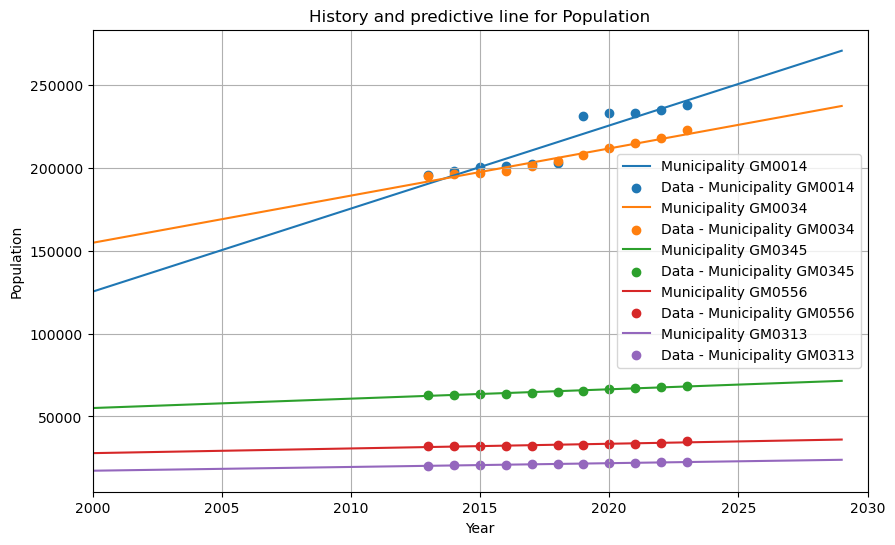

household_size


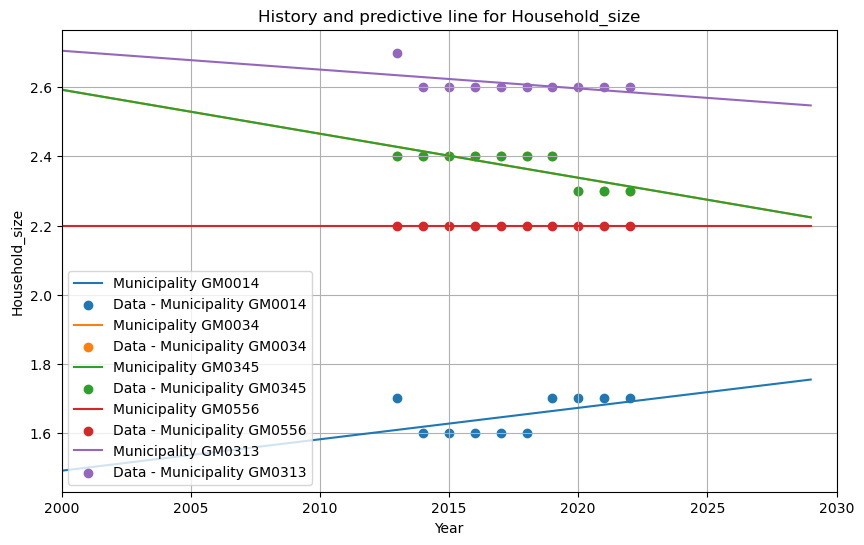

population_density


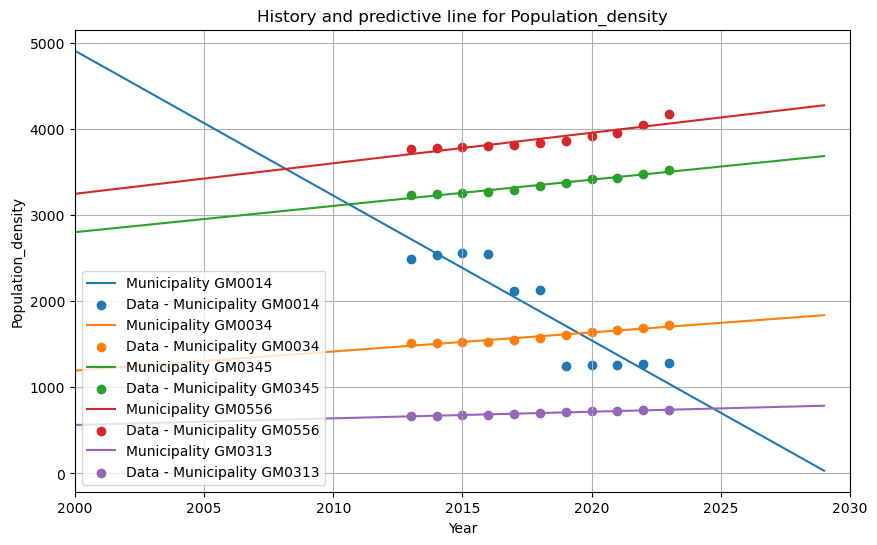

degree_of_urbanity


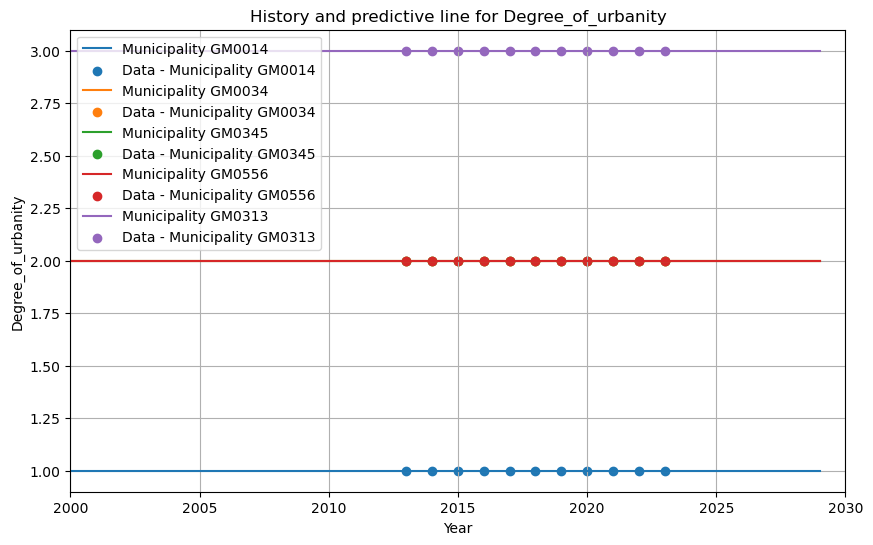

low_educated_population


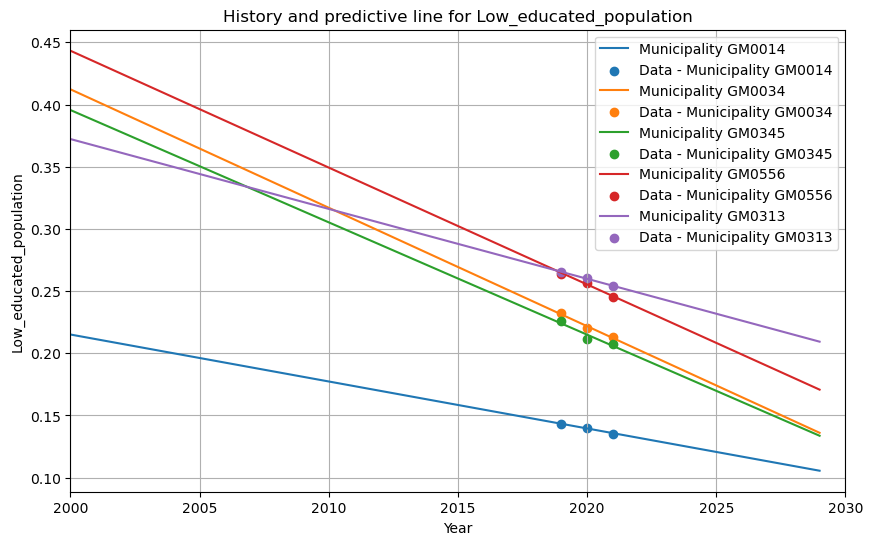

medium_educated_population


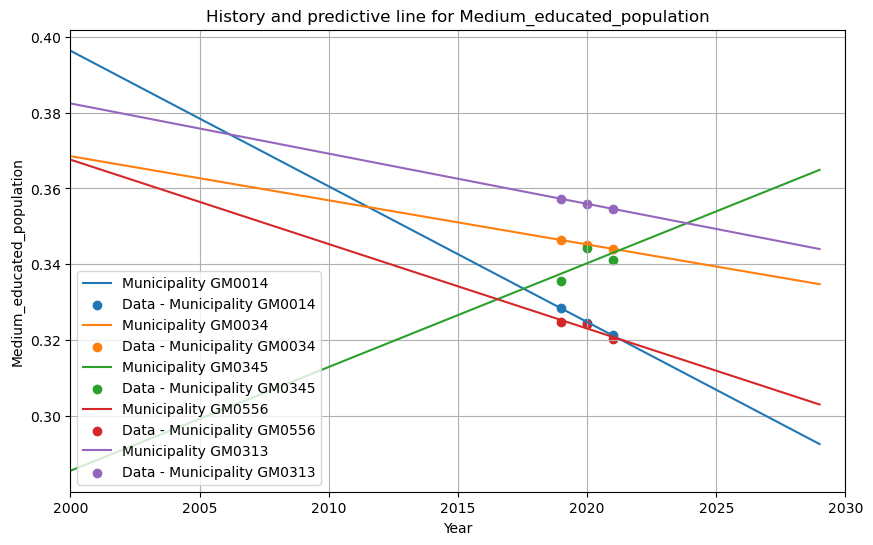

high_educated_population


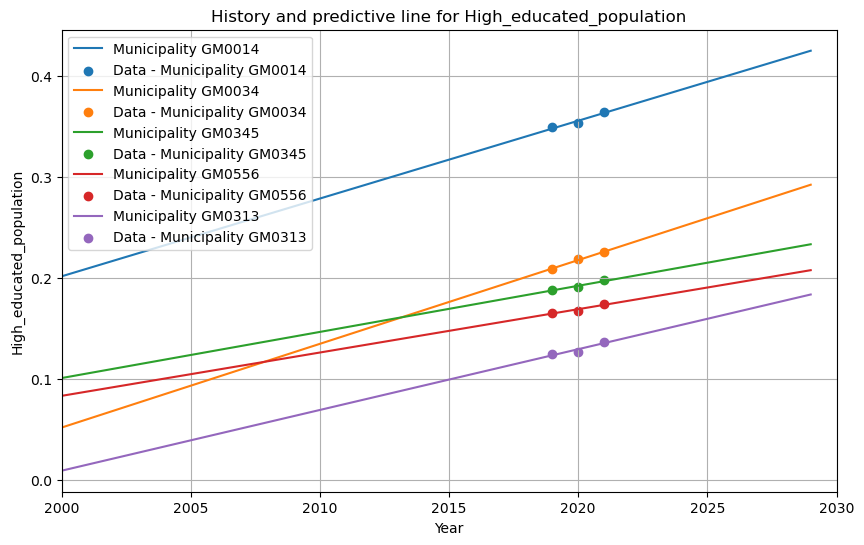

distance_GP


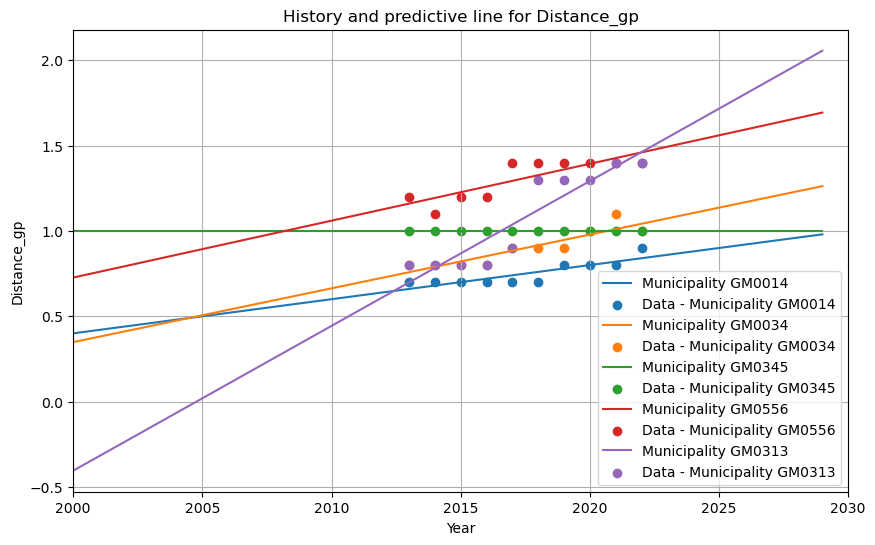

distance_supermarket


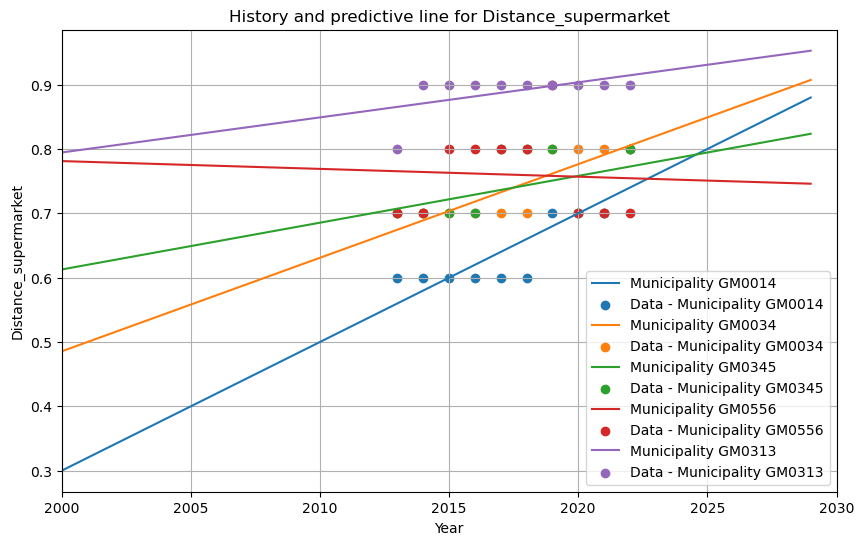

distance_daycare


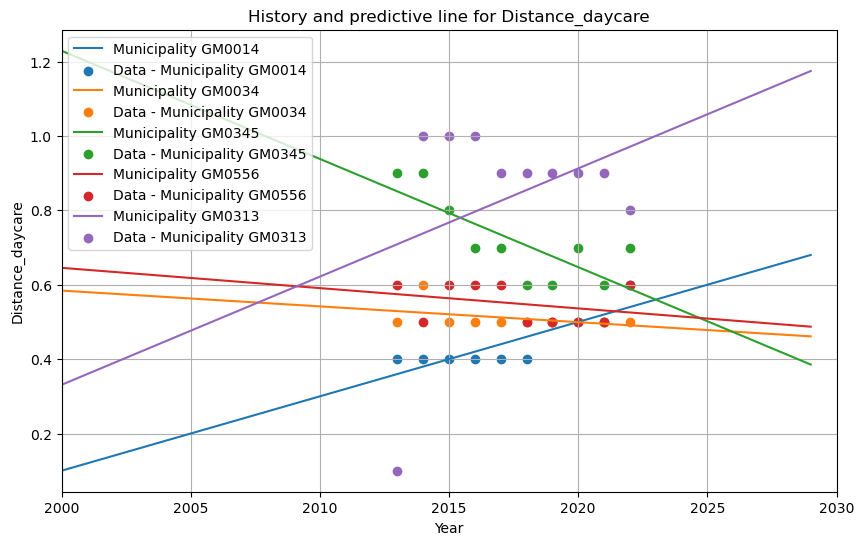

distance_school


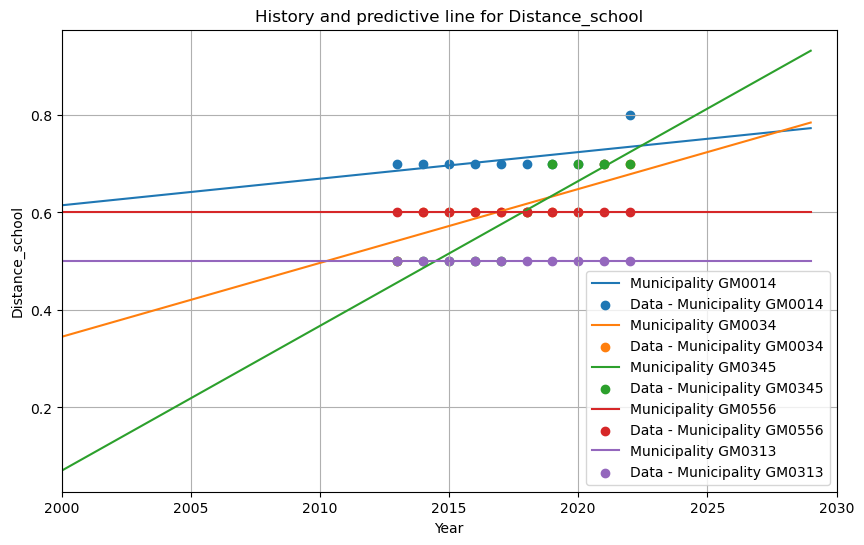

avg_income_per_recipient


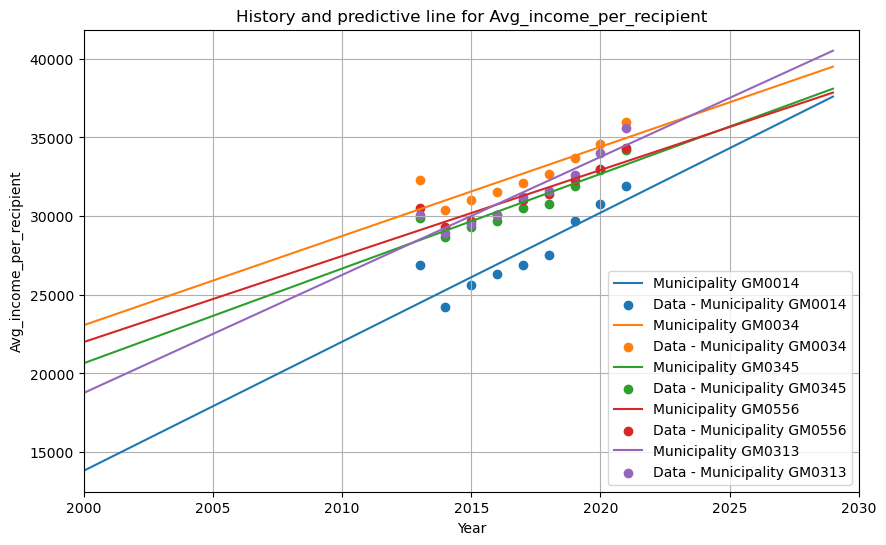

unemployment_rate


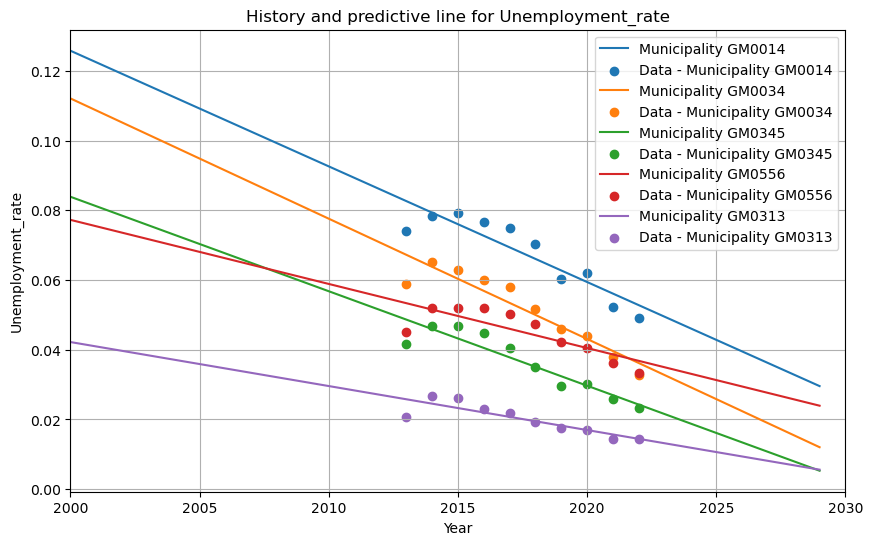

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'coefficients_df' with columns 'municipality_id', 'pop_intercept', and 'pop_slope',
# and another DataFrame called 'pop_df' with columns 'municipality_id', 'year', and 'population'.

def plot_demographic_history(coefficients_df, pop_df, municipality_ids, stat_name = 'population', show_prediction = True, show_datapoints = True, start_year = 2000, end_year = 2030):
    plt.figure(figsize=(10, 6))

    if stat_name+'_intercept' not in coefs_columns:
      print(stat_name,"not present in coefficients set")
      return

    # Create a color map for different municipalities.
    color_map = plt.get_cmap('tab10')

    for i, municipality_id in enumerate(municipality_ids):
        # Filter the data for the specified municipality.
        municipality_data = coefficients_df[coefficients_df['municipality_id'] == municipality_id]
        pop_data = pop_df[pop_df['municipality_id'] == municipality_id]

        plt.xlim(right=end_year) #xmax is your value
        plt.xlim(left=start_year)

        if not municipality_data.empty:
            line_label = f'Municipality {municipality_id}'
            line_color = color_map(i)

            # Plot the regression line for the specified municipality.
            if show_prediction:
              pop_intercept = municipality_data[stat_name + '_intercept'].values[0]
              pop_slope = municipality_data[stat_name + '_slope'].values[0]

              x = list(range(start_year, end_year))
              y = [pop_intercept + pop_slope * xi for xi in x]

              plt.plot(x, y, label=line_label, color=line_color)


            # Plot real data points for the specified municipality.
            if show_datapoints:
              # print("year:",pop_data['year'])
              # print("stat:", pop_data[stat_name])

              plt.scatter(pop_data['year'], pop_data[stat_name].astype(float), label=f'Data - {line_label}', color=line_color)
        else:
          print(f"Municipality {municipality_id} not found in the DataFrame.")

    # Label the axes and add a title.
    plt.xlabel('Year')
    plt.ylabel(stat_name.capitalize())
    plt.title('History and predictive line for ' + stat_name.capitalize())

    # Add a legend to identify each municipality and data points.
    plt.legend()

    # Display the plot.
    plt.grid()
    plt.show()

# Example usage:
municipality_ids_to_plot = ["GM0014", "GM0034", "GM0345","GM0556", "GM0313"]
# municipality_ids_to_plot = ["GM0345"]
# municipality_ids_to_plot = ["GM0003"]
# municipality_ids_to_plot = ["GM0556"]

for stat in feature_names:
# for stat in ['population','labor_force_participation']:
  print(stat)
  plot_demographic_history(coefficients_df, pop_df, municipality_ids_to_plot, stat_name = stat)


In [27]:
# print("coefficients_df\n",coefficients_df)
# print("pop_df\n",pop_df)

# included_years = [2019, 2020, 2021]
# print(pop_df['year'])
# prediction_demo_df = pop_df[pop_df['year'].isin(included_years) == True]
prediction_demo_df = pop_df

# print(prediction_demo_df)

# prediction_crime_score_df = crime_score_df[crime_score_df['year'].isin(included_years) == True]
prediction_crime_score_df = crime_score_df[['municipality_id','year','crime_score']]
# print(prediction_crime_score_df)

prediction_df = pd.merge(left=prediction_demo_df,right=prediction_crime_score_df, how='outer')

# 'GM0088', 'GM0096', 'GM0277' have NaN in 2021 avg_income, can check with prediction_df[prediction_df['avg_income_per_recipient'].isnull()]

prediction_df = prediction_df[prediction_df.avg_income_per_recipient.isnull() != True]        # TODO: could iterate this over all columns of prediction_df to remove all rows with nans
                                                                                              # not doing it right now to make sure the rows i think are included are in fact there

prediction_df.drop(['municipality_id','year', 'low_educated_population', 'medium_educated_population', 'high_educated_population'],axis=1,inplace = True)
print(prediction_df)

# prediction_df[prediction_df['avg_income_per_recipient'].isnull()]
# prediction_df[prediction_df['municipality_id'] == 'GM0088']
# print(prediction_df[prediction_df['municipality_id'] == 'GM0088'].avg_income_per_recipient.isnull())

      population  household_size population_density degree_of_urbanity  \
0         195415             1.7               2497                  1   
1         195210             2.4               1510                  2   
2          32885             2.2                280                  4   
3          27915             2.2                367                  4   
4          21260             2.6                 86                  4   
...          ...             ...                ...                ...   
2943       47834             2.2                 99                  5   
2944       63678             2.4                176                  5   
2945       45481             2.3                120                  5   
2946       44130             2.6                243                  5   
2947       45587             2.1                170                  4   

      distance_GP  distance_supermarket  distance_daycare  distance_school  \
0             0.7                

all crime
count             3286
unique               3
top       medium_crime
freq              1892
Name: crime_score, dtype: object


<Axes: title={'center': 'Crime score distribution 2013-2022'}, xlabel='Crime score', ylabel='Count'>

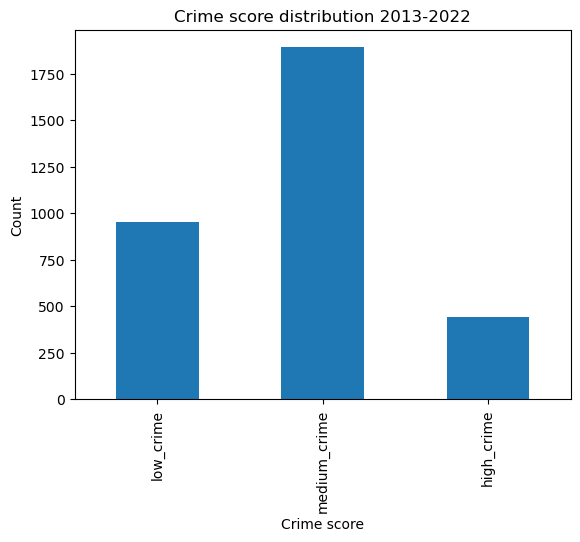

In [28]:
print("all crime")
print(crime_score_df['crime_score'].describe())
# print(crime_score_df)
crime_score_df['crime_score'].value_counts().sort_index().plot.bar(x='crime_score',title="Crime score distribution 2013-2022", xlabel = "Crime score", ylabel = "Count")


crime from 2019 to 2021
count             2945
unique               3
top       medium_crime
freq              1733
Name: crime_score, dtype: object


<Axes: title={'center': 'Crime score distribution 2019-2021'}, xlabel='Crime score', ylabel='Count'>

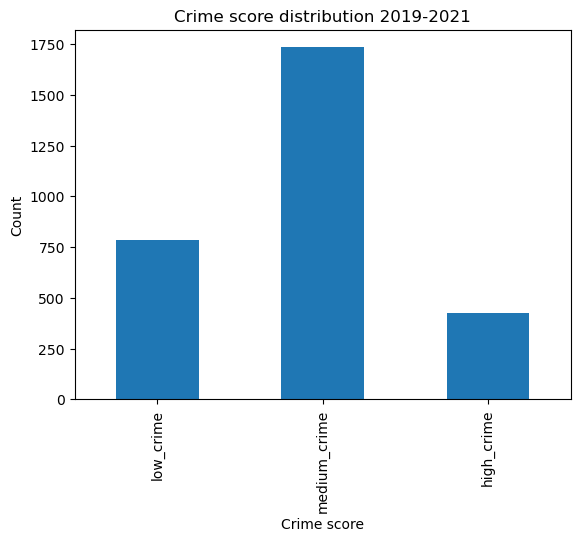

In [29]:
print("crime from 2019 to 2021")
print(prediction_df['crime_score'].describe())
prediction_df['crime_score'].value_counts().sort_index().plot.bar(title="Crime score distribution 2019-2021", xlabel = "Crime score", ylabel = "Count")

crime of 2013
count              319
unique               3
top       medium_crime
freq               191
Name: crime_score, dtype: object


<Axes: title={'center': 'Crime score distribution 2013'}, xlabel='Crime score', ylabel='Count'>

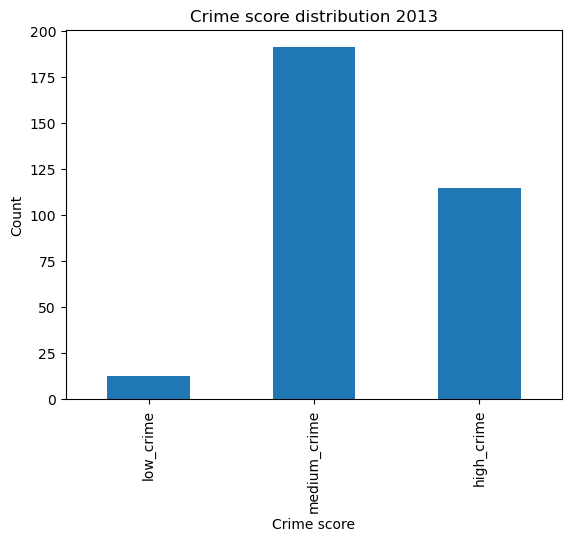

In [30]:
particular_year = 2013
print("crime of",particular_year)
latest_crime_df = crime_score_df[crime_score_df['year'].isin([particular_year]) == True]
print(latest_crime_df['crime_score'].describe())
latest_crime_df['crime_score'].value_counts().sort_index().plot.bar(title="Crime score distribution "+str(particular_year), xlabel = "Crime score", ylabel = "Count")

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

y = prediction_df['crime_score']
X = prediction_df.drop('crime_score', axis=1)

feature_names = list(X.columns)

print("Crime score distribution 2019-2021")
print(prediction_df['crime_score'].value_counts().sort_index())
# print(X,y)

# Training set: 70%; Test set: 15%, Validation Set: 15%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=69, stratify=y)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state=420, stratify=y_test)

print(len(X_train), len(X_test), len(X_val))



Crime score distribution 2019-2021
crime_score
low_crime        787
medium_crime    1733
high_crime       425
Name: count, dtype: int64
2061 442 442


In [32]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV

# rf_classifier = RandomForestClassifier(n_estimators=20, random_state=427, n_jobs = -1)
# rf_classifier.fit(X_train, y_train)

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2,5,10],
#     'min_samples_leaf': [1,2,4],
#     'max_features': ['sqrt','log2',None],
#     # 'class_weight': [None,"balanced", "balanced_subsample"]
#     # Add more hyperparameters to search here
# }

# grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
# grid_search.fit(X_val, y_val)

# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

X_train_val = pd.concat([X_train, X_val], axis = 0)
y_train_val = pd.concat([y_train, y_val], axis = 0)

best_params_custom = {
    'n_estimators': 300,
    'min_samples_split': 10,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 10,
    'class_weight': 'balanced_subsample'
}

best_params_custom_unweighted = {
    'n_estimators': 300,
    'min_samples_split': 10,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 10,
    'class_weight': 'None'
}

In [34]:
# from sklearn.metrics._plot.precision_recall_curve import average_precision_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

rf_classifier = RandomForestClassifier(random_state=427, n_estimators=best_params_custom['n_estimators'],
                                       max_depth=best_params_custom['max_depth'],
                                       min_samples_split = best_params_custom['min_samples_split'],
                                       min_samples_leaf = best_params_custom['min_samples_leaf'],
                                       class_weight = best_params_custom['class_weight'],
                                    #   class_weight = 'balanced_subsample',
                                       max_features = best_params_custom['max_features'])
rf_classifier.fit(X_train_val, y_train_val)


y_test_pred = rf_classifier.predict(X_test)
y_test_true = np.array(y_test)

# for i in range(len(y_test_pred)):
#   print(y_test_pred[i], y_test_arr[i])

print("Hyperparameters:", best_params_custom)
print(f"RF train accuracy: {rf_classifier.score(X_train_val, y_train_val):.3f}")
print(f"RF test accuracy: {rf_classifier.score(X_test, y_test):.3f}")
# print("accuracy:",accuracy_score(y_true = y_test_true, y_pred = y_test_pred))
print("average recall:",balanced_accuracy_score(y_true = y_test_true, y_pred = y_test_pred)) #avg recall
print(classification_report(y_true = y_test_true, y_pred = y_test_pred))


Hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'balanced_subsample'}
RF train accuracy: 0.890
RF test accuracy: 0.756
average recall: 0.7501887766188613
              precision    recall  f1-score   support

  high_crime       0.72      0.77      0.74        64
   low_crime       0.67      0.71      0.69       118
medium_crime       0.81      0.77      0.79       260

    accuracy                           0.76       442
   macro avg       0.73      0.75      0.74       442
weighted avg       0.76      0.76      0.76       442



In [35]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=427)

X_train_val_resampled, y_train_val_resampled = smote.fit_resample(X_train_val, y_train_val)

# from sklearn.metrics._plot.precision_recall_curve import average_precision_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

rf_classifier_resampled = RandomForestClassifier(random_state=427, n_estimators=best_params_custom['n_estimators'],
                                       max_depth=best_params_custom['max_depth'],
                                       min_samples_split = best_params_custom['min_samples_split'],
                                       min_samples_leaf = best_params_custom['min_samples_leaf'],
                                       class_weight = best_params_custom['class_weight'],
                                    #   class_weight = 'balanced_subsample',
                                       max_features = best_params_custom['max_features'])
rf_classifier_resampled.fit(X_train_val_resampled, y_train_val_resampled)


y_test_pred_resampled = rf_classifier_resampled.predict(X_test)
y_test_true_resampled = np.array(y_test)

# for i in range(len(y_test_pred)):
#   print(y_test_pred[i], y_test_arr[i])

print("Hyperparameters:", best_params_custom)
print(f"RF train accuracy: {rf_classifier_resampled.score(X_train_val_resampled, y_train_val_resampled):.3f}")
print(f"RF test accuracy: {rf_classifier_resampled.score(X_test, y_test):.3f}")
# print("accuracy:",accuracy_score(y_true = y_test_true_resampled, y_pred = y_test_pred_resampled))
print("average recall:",balanced_accuracy_score(y_true = y_test_true_resampled, y_pred = y_test_pred_resampled)) #avg recall
print(classification_report(y_true = y_test_true_resampled, y_pred = y_test_pred_resampled))



Hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'balanced_subsample'}
RF train accuracy: 0.930
RF test accuracy: 0.765
average recall: 0.7600839308996088
              precision    recall  f1-score   support

  high_crime       0.72      0.80      0.76        64
   low_crime       0.69      0.69      0.69       118
medium_crime       0.81      0.79      0.80       260

    accuracy                           0.76       442
   macro avg       0.74      0.76      0.75       442
weighted avg       0.77      0.76      0.77       442



In [36]:
feature_names

['population',
 'household_size',
 'population_density',
 'degree_of_urbanity',
 'distance_GP',
 'distance_supermarket',
 'distance_daycare',
 'distance_school',
 'avg_income_per_recipient',
 'unemployment_rate']

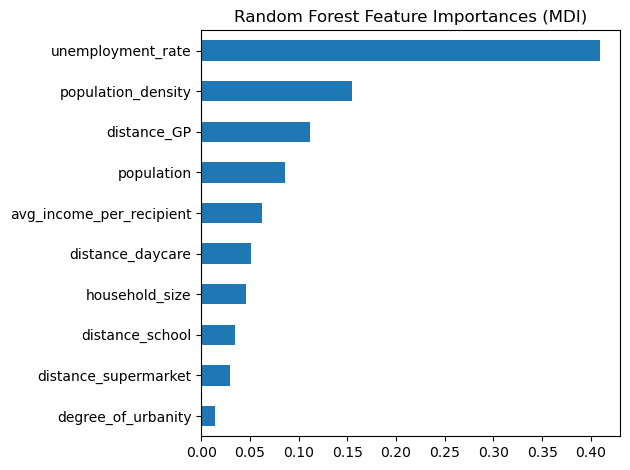

In [37]:
mdi_importances = pd.Series(
    rf_classifier[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

RF train accuracy: 0.890
RF test accuracy: 0.756


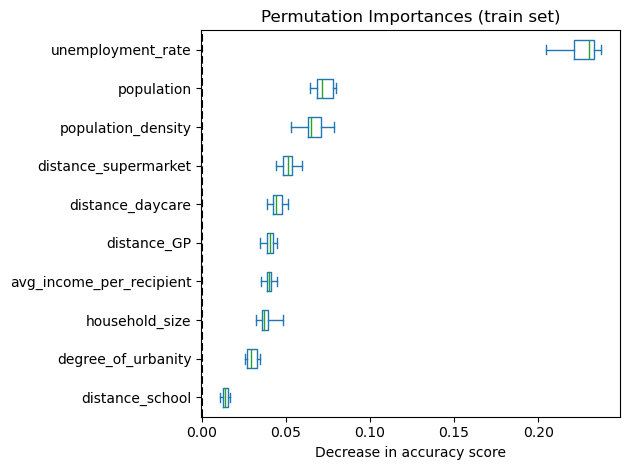

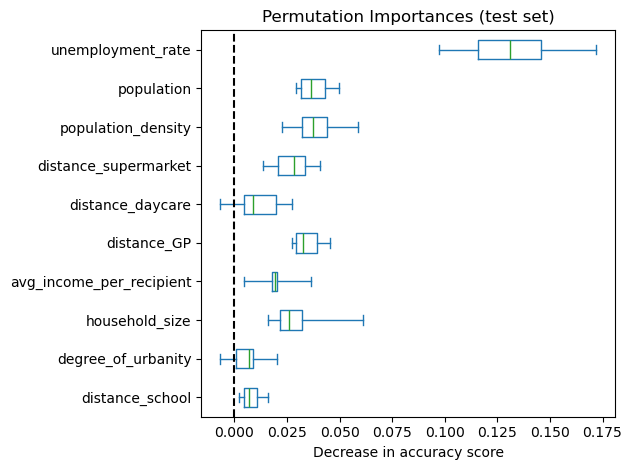

In [38]:
from sklearn.inspection import permutation_importance

print(f"RF train accuracy: {rf_classifier.score(X_train_val, y_train_val):.3f}")
print(f"RF test accuracy: {rf_classifier.score(X_test, y_test):.3f}")


train_result = permutation_importance(
    rf_classifier, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
test_results = permutation_importance(
    rf_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = train_result.importances_mean.argsort()

train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)")
# ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score")
# ax.figure.tight_layout()

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

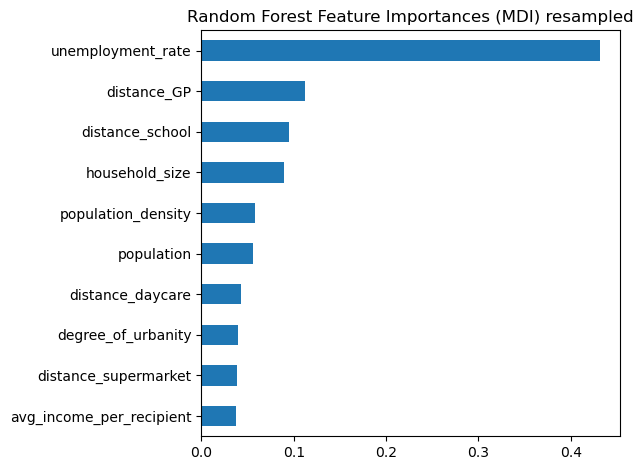

In [39]:
mdi_importances = pd.Series(
    rf_classifier_resampled[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI) resampled")
ax.figure.tight_layout()

RF train accuracy: 0.930
RF test accuracy: 0.765


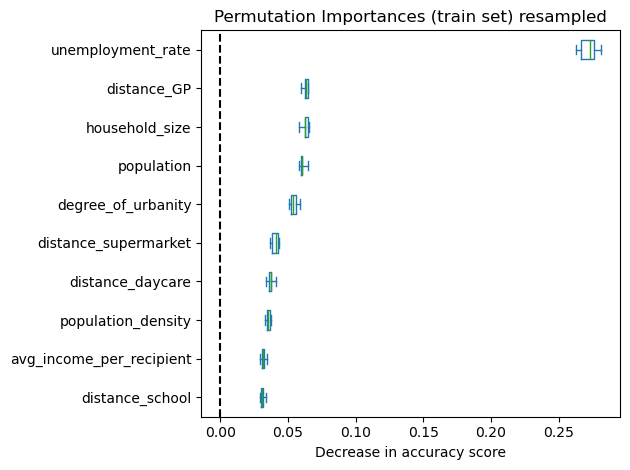

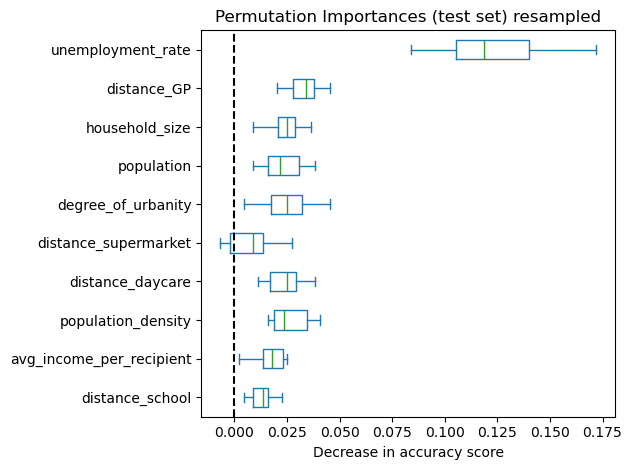

In [40]:
from sklearn.inspection import permutation_importance

print(f"RF train accuracy: {rf_classifier_resampled.score(X_train_val_resampled, y_train_val_resampled):.3f}")
print(f"RF test accuracy: {rf_classifier_resampled.score(X_test, y_test):.3f}")


train_result = permutation_importance(
    rf_classifier_resampled, X_train_val_resampled, y_train_val_resampled, n_repeats=10, random_state=42, n_jobs=2
)
test_results = permutation_importance(
    rf_classifier_resampled, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = train_result.importances_mean.argsort()

train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)")
# ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score")
# ax.figure.tight_layout()

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set) resampled")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

In [41]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=427)

X_train_val_oversampled, y_train_val_oversampled = smote.fit_resample(X_train_val, y_train_val)

# from sklearn.metrics._plot.precision_recall_curve import average_precision_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

rf_classifier_oversampled = RandomForestClassifier(random_state=427, n_estimators=best_params_custom['n_estimators'],
                                       max_depth=best_params_custom['max_depth'],
                                       min_samples_split = best_params_custom['min_samples_split'],
                                       min_samples_leaf = best_params_custom['min_samples_leaf'],
                                      #  class_weight = best_params_custom['class_weight'],
                                      # class_weight = None,
                                       max_features = best_params_custom['max_features'])
rf_classifier_oversampled.fit(X_train_val_oversampled, y_train_val_oversampled)


y_test_pred_oversampled = rf_classifier_oversampled.predict(X_test)
y_test_true_oversampled = np.array(y_test)

# for i in range(len(y_test_pred)):
#   print(y_test_pred[i], y_test_arr[i])

print("Hyperparameters:", best_params_custom_unweighted)
print(f"RF train accuracy: {rf_classifier_oversampled.score(X_train_val_oversampled, y_train_val_oversampled):.3f}")
print(f"RF test accuracy: {rf_classifier_oversampled.score(X_test, y_test):.3f}")
# print("accuracy:",accuracy_score(y_true = y_test_true_oversampled, y_pred = y_test_pred_oversampled))
print("average recall:",balanced_accuracy_score(y_true = y_test_true_oversampled, y_pred = y_test_pred_oversampled)) #avg recall
print(classification_report(y_true = y_test_true_oversampled, y_pred = y_test_pred_oversampled))



Hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'None'}
RF train accuracy: 0.933
RF test accuracy: 0.762
average recall: 0.7627281616688396
              precision    recall  f1-score   support

  high_crime       0.70      0.81      0.75        64
   low_crime       0.69      0.69      0.69       118
medium_crime       0.81      0.78      0.80       260

    accuracy                           0.76       442
   macro avg       0.74      0.76      0.75       442
weighted avg       0.76      0.76      0.76       442



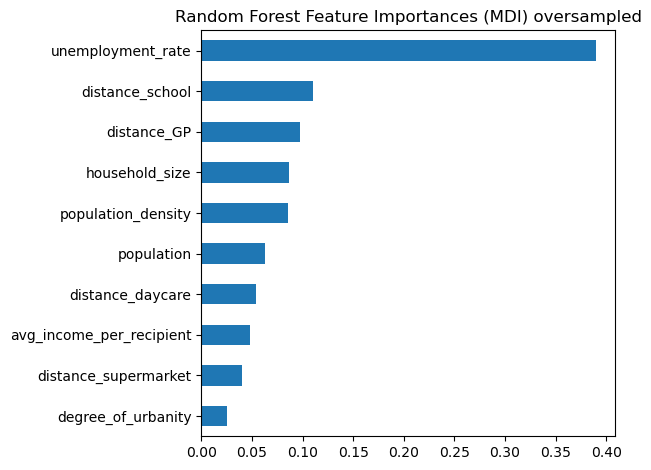

In [42]:
mdi_importances = pd.Series(
    rf_classifier_oversampled[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI) oversampled")
ax.figure.tight_layout()

RF train accuracy: 0.933
RF test accuracy: 0.762


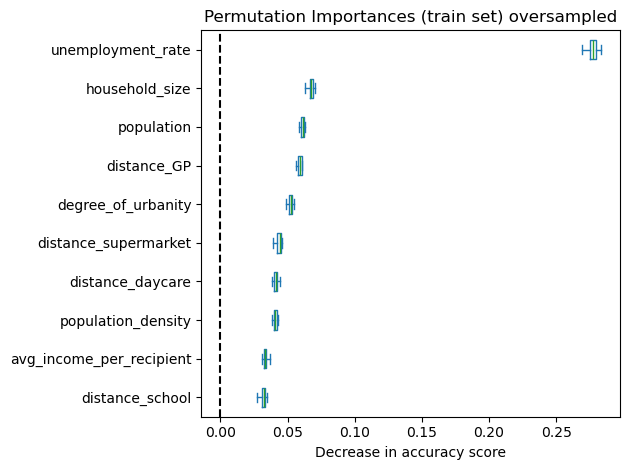

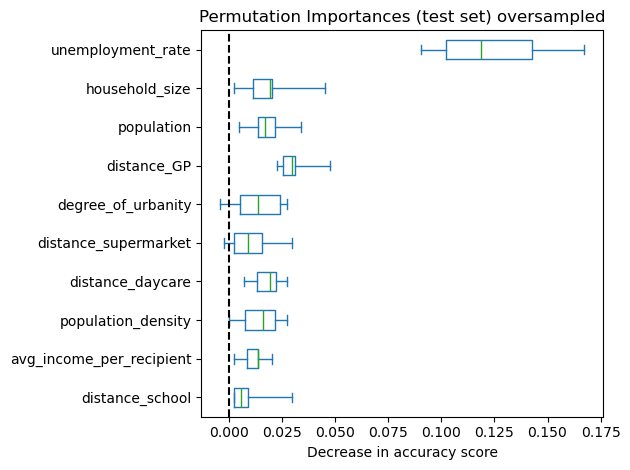

In [43]:
from sklearn.inspection import permutation_importance

print(f"RF train accuracy: {rf_classifier_oversampled.score(X_train_val_oversampled, y_train_val_oversampled):.3f}")
print(f"RF test accuracy: {rf_classifier_oversampled.score(X_test, y_test):.3f}")


train_result = permutation_importance(
    rf_classifier_oversampled, X_train_val_oversampled, y_train_val_oversampled, n_repeats=10, random_state=42, n_jobs=2
)
test_results = permutation_importance(
    rf_classifier_oversampled, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = train_result.importances_mean.argsort()

train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)")
# ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score")
# ax.figure.tight_layout()

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set) oversampled")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

In [44]:
selected_features = ['population',
 'household_size',
 'population_density',
 'degree_of_urbanity',
 'distance_GP',
 'distance_supermarket',
 'distance_daycare',
 'distance_school',
 'avg_income_per_recipient']#,
#  'unemployment_rate']

X_train_selected = X_train[selected_features]
X_val_selected =  X_val[selected_features]
X_test_selected = X_test[selected_features]


print("Selected Feature Names:", selected_features)


rf_classifier_selected = RandomForestClassifier(random_state=427, n_estimators=best_params_custom['n_estimators'],
                                       max_depth=best_params_custom['max_depth'],
                                       min_samples_split = best_params_custom['min_samples_split'],
                                       min_samples_leaf = best_params_custom['min_samples_leaf'],
                                       class_weight = best_params_custom['class_weight'],
                                    #   class_weight = 'balanced_subsample',
                                       max_features = best_params_custom['max_features'])
rf_classifier_selected.fit(X_train_selected, y_train)


y_test_pred_selected = rf_classifier_selected.predict(X_test_selected)
y_test_true_selected = np.array(y_test)

# for i in range(len(y_test_pred)):
#   print(y_test_pred[i], y_test_arr[i])

print("Hyperparameters:", best_params_custom_unweighted)
print(f"RF train accuracy: {rf_classifier_selected.score(X_train_selected, y_train):.3f}")
print(f"RF test accuracy: {rf_classifier_selected.score(X_test_selected, y_test):.3f}")
print("accuracy:",accuracy_score(y_true = y_test_true_selected, y_pred = y_test_pred_selected))
print("average recall:",balanced_accuracy_score(y_true = y_test_true_selected, y_pred = y_test_pred_selected)) #avg recall
print(classification_report(y_true = y_test_true_selected, y_pred = y_test_pred_selected))


Selected Feature Names: ['population', 'household_size', 'population_density', 'degree_of_urbanity', 'distance_GP', 'distance_supermarket', 'distance_daycare', 'distance_school', 'avg_income_per_recipient']
Hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'None'}
RF train accuracy: 0.879
RF test accuracy: 0.726
accuracy: 0.7262443438914027
average recall: 0.7434810951760106
              precision    recall  f1-score   support

  high_crime       0.70      0.75      0.72        64
   low_crime       0.60      0.79      0.68       118
medium_crime       0.82      0.69      0.75       260

    accuracy                           0.73       442
   macro avg       0.71      0.74      0.72       442
weighted avg       0.75      0.73      0.73       442



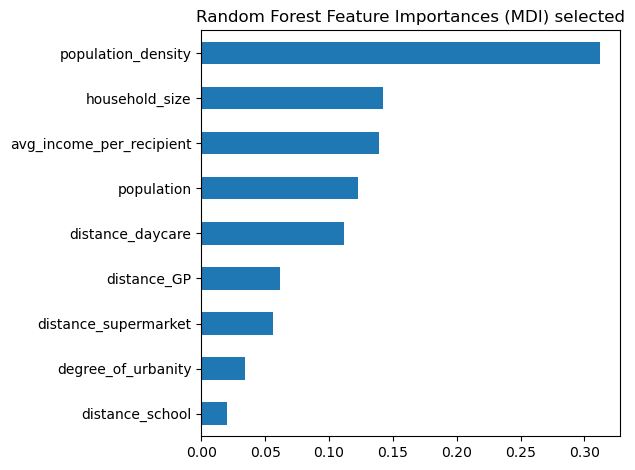

In [45]:
mdi_importances = pd.Series(
    rf_classifier_selected[-1].feature_importances_, index=selected_features
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI) selected")
ax.figure.tight_layout()

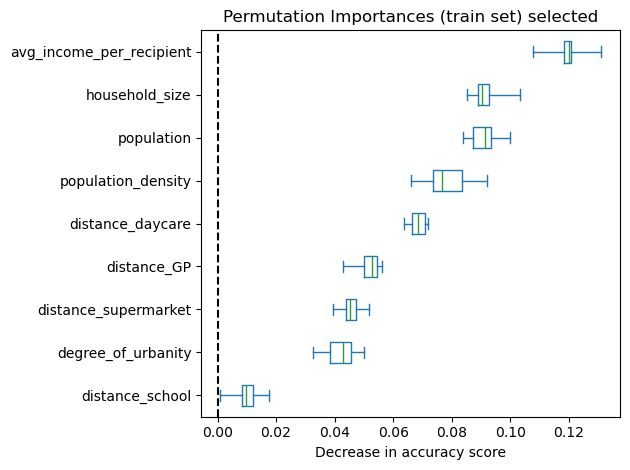

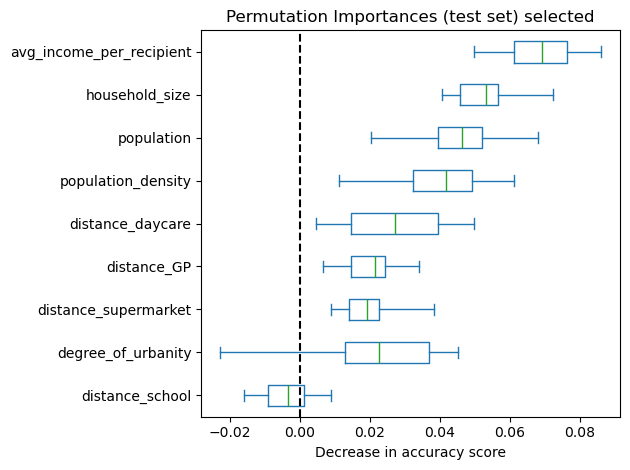

In [46]:
from sklearn.inspection import permutation_importance


train_result = permutation_importance(
    rf_classifier_selected, X_train_selected, y_train, n_repeats=10, random_state=42, n_jobs=2
)
test_results = permutation_importance(
    rf_classifier_selected, X_test_selected, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = train_result.importances_mean.argsort()

train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)")
# ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score")
# ax.figure.tight_layout()

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set) selected")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

In [47]:
# from sklearn import datasets
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.model_selection import GridSearchCV

# svm_classifier = SVC(kernel='linear', C=1.0)  # You can choose different kernels and hyperparameters
# svm_classifier.fit(X_train, y_train)
# y_pred = svm_classifier.predict(X_test)

# # param_grid = {
# #     'C': [0.1, 1, 10],
# #     'kernel': ['linear', 'rbf', 'poly'],
# # }

# # grid_search = GridSearchCV(SVC(), param_grid, cv=5)
# # grid_search.fit(X_train, y_train)

# # best_params = grid_search.best_params_
# # print("Best Parameters:", best_params)

# # best_svm_classifier = grid_search.best_estimator_
# # y_pred = best_svm_classifier.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)
# classification_rep = classification_report(y_test, y_pred)

# print(f'Accuracy: {accuracy}')
# print(f'Confusion Matrix:\n{conf_matrix}')
# print(f'Classification Report:\n{classification_rep}')


In [48]:
# from sklearn import datasets
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.model_selection import GridSearchCV

# svm_classifier = SVC(kernel='linear', C=1.0, decision_function_shape='ovr')  # You can choose different kernels and hyperparameters
# svm_classifier.fit(X_train, y_train)
# y_pred = svm_classifier.predict(X_test)

# # param_grid = {
# #     'C': [0.1, 1, 10],
# #     'kernel': ['linear', 'rbf', 'poly'],
# # }

# # grid_search = GridSearchCV(SVC(), param_grid, cv=5)
# # grid_search.fit(X_train, y_train)

# # best_params = grid_search.best_params_
# # print("Best Parameters:", best_params)

# # best_svm_classifier = grid_search.best_estimator_
# # y_pred = best_svm_classifier.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)
# classification_rep = classification_report(y_test, y_pred)

# print(f'Accuracy: {accuracy}')
# print(f'Confusion Matrix:\n{conf_matrix}')
# print(f'Classification Report:\n{classification_rep}')

In [49]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=427)


X_full_oversampled, y_full_oversampled = smote.fit_resample(X, y)

# from sklearn.metrics._plot.precision_recall_curve import average_precision_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

final_rf_classifier = RandomForestClassifier(random_state=427, n_estimators=best_params_custom['n_estimators'],
                                       max_depth=best_params_custom['max_depth'],
                                       min_samples_split = best_params_custom['min_samples_split'],
                                       min_samples_leaf = best_params_custom['min_samples_leaf'],
                                      #  class_weight = best_params_custom['class_weight'],
                                      # class_weight = None,
                                       max_features = best_params_custom['max_features'])
final_rf_classifier.fit(X_full_oversampled, y_full_oversampled)

y_pred_full_oversampled = final_rf_classifier.predict(X_full_oversampled)
y_true_full_oversampled = np.array(y_full_oversampled)

print("Hyperparameters:", best_params_custom_unweighted)
print("final training set accuracy:",accuracy_score(y_true = y_true_full_oversampled, y_pred = y_pred_full_oversampled))
print("final training set average recall:",balanced_accuracy_score(y_true = y_true_full_oversampled, y_pred = y_pred_full_oversampled)) #avg recall
print("final training set classification report:")
print(classification_report(y_true = y_true_full_oversampled, y_pred = y_pred_full_oversampled))


Hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'None'}
final training set accuracy: 0.9269090209655703
final training set average recall: 0.9269090209655703
final training set classification report:
              precision    recall  f1-score   support

  high_crime       0.97      0.95      0.96      1733
   low_crime       0.90      0.95      0.92      1733
medium_crime       0.92      0.88      0.90      1733

    accuracy                           0.93      5199
   macro avg       0.93      0.93      0.93      5199
weighted avg       0.93      0.93      0.93      5199



In [50]:
def get_demographic_value(GM_id, stat, year):
  try:    #check for existing value first
    value = float(clean_demo_data.loc[clean_demo_data['municipality_id'] == GM_id].loc[clean_demo_data['year'] == year][stat])

  except: # if no existing value is found, extrapolate from linear regression coefficients table
    slope = coefficients_df[stat + "_slope"][coefficients_df['municipality_id'] == GM_id]
    intercept = coefficients_df[stat + "_intercept"][coefficients_df['municipality_id'] == GM_id]
    value = float(year * slope + intercept)

    # if the value goes to zero due to a downwards trend, use the last non-zero prediction
    while value <= 0:
      year -= 1
      value = float(year * slope + intercept)

  return value


print("unemployment rate in GM0014:")
print("2010:",get_demographic_value("GM0014","unemployment_rate",2010))
print("2015:",get_demographic_value("GM0014","unemployment_rate",2015))
print("2020:",get_demographic_value("GM0014","unemployment_rate",2020))
print("2025:",get_demographic_value("GM0014","unemployment_rate",2025))
print("2030:",get_demographic_value("GM0014","unemployment_rate",2030))
print("2035",get_demographic_value("GM0014","unemployment_rate",2035))
print("2040:",get_demographic_value("GM0014","unemployment_rate",2040))
print("2045:",get_demographic_value("GM0014","unemployment_rate",2045))
print("2045:",get_demographic_value("GM0014","unemployment_rate",2050), '\n')


def get_all_default_predictions(GM_id, year):
  values = []
  for feature in feature_names:
    value = get_demographic_value(GM_id, feature, year)
    # values[feature] = value
    values.append(value)
  # print(values)
  values_df = pd.DataFrame(columns = feature_names)
  values_df.loc[0] = values
  return values_df


def predict_crime_class(GM_id, year, classifier = final_rf_classifier):
  values_df = get_all_default_predictions(GM_id, year)
  return str(classifier.predict(values_df)[0])

print("all predictions in GM0014 in 2033")
print(get_all_default_predictions("GM0014", 2033), '\n')

print("crime category prediction in GM0014 in 2033 is:", predict_crime_class("GM0014", 2033))


unemployment rate in GM0014:
2010: 0.09262865136084208
2015: 0.07936666400447248
2020: 0.06200778103180261
2025: 0.04285520472751614
2030: 0.02626405584974112
2035 0.009672906971965212
2040: 0.003036447420855737
2045: 0.003036447420855737
2045: 0.003036447420855737 

all predictions in GM0014 in 2033
      population  household_size  population_density  degree_of_urbanity  \
0  290753.090909        1.790909           31.636364                 1.0   

   distance_GP  distance_supermarket  distance_daycare  distance_school  \
0         1.06                  0.96              0.76         0.794545   

   avg_income_per_recipient  unemployment_rate  
0              40875.555556           0.016309   

crime category prediction in GM0014 in 2033 is: medium_crime


/tmp/ipykernel_426/2843312692.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(year * slope + intercept)
/tmp/ipykernel_426/2843312692.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(clean_demo_data.loc[clean_demo_data['municipality_id'] == GM_id].loc[clean_demo_data['year'] == year][stat])
/tmp/ipykernel_426/2843312692.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(clean_demo_data.loc[clean_demo_data['municipality_id'] == GM_id].loc[clean_demo_data['year'] == year][stat])
/tmp/ipykernel_426/2843312692.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) 